In [46]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import seaborn as sns
from matplotlib.ticker import LogLocator

**SYSTEMS FUNCTIONS**

notes:
- for LDS: can try inital hidden state 0.
- for NAR: can try to change p, can try to bound initial states, as well as matrices A.
- for RNN: can see how we define the weight matrix.

In [2]:
def system_lds(T, d_hid, d_in, d_out=1, seed=0):
    """
    Simulates a Linear Dynamical System (LDS) according to the equations:
        x_{t+1} = A x_t + B u_t
        y_t     = C x_t
    
    ARGS:
        T      : int       (number of time steps)
        d_hid  : int       (hidden state dimension)
        d_in   : int       (input dimension)
        d_out  : int       (output dimension)
        seed   : int       (random seed for reproducibility)

    Returns:
        U ∈ ℝ^{T×d_in}  (inputs)
        Y ∈ ℝ^{T×d_out} (observed output)
    """
    np.random.seed(seed)

    # Real diagonalizable A with eigenvalues in (-1, 1)
    Q, _ = np.linalg.qr(np.random.randn(d_hid, d_hid))
    eigvals = np.random.uniform(-1, 1, size=d_hid)
    A = Q @ np.diag(eigvals) @ Q.T

    # Random system matrices
    B = np.random.randn(d_hid, d_in)
    C = np.random.randn(d_out, d_hid)

    # Initial state and storage
    x = np.random.uniform(-1, 1, size=(d_hid, 1)) # random initial hidden state
    U = np.zeros((T, d_in))     # inputs matrix
    Y = np.zeros((T, d_out))    # observed output matrix

    # Simulate
    for t in range(T):
        u = np.random.uniform(-1, 1, size=(d_in, 1)) # random input at each step
        U[t] = u.flatten()             # store input
        y = C @ x                      # compute output
        Y[t] = y.flatten()             # store output
        x = A @ x + B @ u              # state update

    return U, Y

In [6]:
def system_nar(T, d_out=1, p=2, seed=0):
    """
    Simulates a Nonlinear Autoregressive (NAR) system according to the equation:
        x_t = tanh(sum_k A_k @ x_{t-k})

    ARGS:
        T      : int       (number of time steps)
        d_out  : int       (output dimension)
        p      : int       (order of the autoregressive model)
        seed   : int       (random seed for reproducibility)
    
    Returns:
        X ∈ ℝ^{T×d_out}  (observed output)
    """

    np.random.seed(seed)

    A_k = [0.8 * np.random.randn(d_out, d_out)/np.sqrt(d_out) for _ in range(p)] # p - A (dxd) matrices   
    X = np.zeros((T, d_out))        # observed output matrix

    # random initial states
    for i in range(p):
        X[i] = np.random.randn(d_out)

    for t in range(p, T):
      past_states = [X[t-k] for k in range(1, p+1)] # collect past p states
      x_t = np.zeros(d_out)
      for k in range(1, p+1):
          x_t += A_k[k-1] @ X[t-k]
      X[t] = np.tanh(x_t)
      
    return X

In [7]:
def system_logistic(T, d_out=1, r=2.0, seed=0):
    """
    Simulate a Logistic map system according to the equation:
        x[t+1] = r * x[t] * (1 - x[t])
    (nonlinear, chaotic for r>3.57)

    ARGS:
        T      : int       (number of time steps)
        d_out  : int       (output dimension)
        r      : float     (logistic map parameter)
        seed   : int       (random seed for reproducibility)

    Returns:
        X ∈ ℝ^{T×d_out}  (observed output)
    """

    np.random.seed(seed)

    X = np.zeros((T, d_out))
    x0 = np.random.rand(d_out)

    X[0] = x0
    for t in range(T-1):
        X[t+1] = r*X[t]*(1.0 - X[t])

    return X

In [8]:
def system_lorenz(T, sigma=10.0, beta=8.0/3.0, rho=28.0, dt=0.01, seed=0):
    """
    Simulates the Lorenz system according to the equations:
        dx/dt = sigma * (y - x)
        dy/dt = x * (rho - z) - y
        dz/dt = x * y - beta * z

    ARGS:
        T      : int       (number of time steps)
        sigma  : float     (Lorenz parameter)
        beta   : float     (Lorenz parameter)
        rho    : float     (Lorenz parameter)
        dt     : float     (time step size)
        seed   : int       (random seed for reproducibility)

    Returns:
        X ∈ ℝ^{T×3}  (observed output)
    """
    np.random.seed(seed)

    # Lorenz dynamics
    def f(x):
        return np.array([
            sigma*(x[1] - x[0]),
            x[0]*(rho - x[2]) - x[1],
            x[0]*x[1] - beta*x[2]
        ])

    # Simulate true 3D system
    X  = np.zeros((T, 3))

    x = x0 = np.array([1.0, 1.0, 1.0])
    X[0] = x0
    for t in range(T):
        k1 = f(x)
        k2 = f(x + 0.5*dt*k1)
        k3 = f(x + 0.5*dt*k2)
        k4 = f(x + dt*k3)
        x = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        X[t] = x
    return X

In [9]:
def system_rnn(T, d_out=1, rho_h=0.95, seed=0):
    """
     Simulates a Recurrent Neural Network (RNN) system according to the equation:
        x_{t+1} = tanh(Wx * x_t)

     ARGS:
        T      : int       (number of time steps)
        d_out  : int       (output dimension)
        rho_h  : float     (desired spectral radius of the weight matrix)
        seed   : int       (random seed for reproducibility)
    
    Returns:
        X ∈ ℝ^{T×d_out}    (observed output)
    """
    np.random.seed(seed)

    W = np.random.randn(d_out, d_out) / np.sqrt(d_out)    # weight matrix
    spec = np.linalg.svd(W, compute_uv=False)[0]
    W_h = (rho_h / spec) * W                  # Scale W so that its spectral norm ≈ rho_h
    X = np.zeros((T, d_out))
    X[0] = np.random.randn(d_out)
    for t in range(T - 1):
        X[t+1] = np.tanh(W_h @ X[t])
    return X

**BASES FUNCTIONS**

In [11]:
def construct_hankel_matrix(T):
    # Construct the hankel matirx Z
    Z = np.zeros((T, T))
    for i in range(T):
        for j in range(T):
            Z[i, j] = 2 / (((i + j + 2)**3) - (i + j + 2))

        # Compute eigenvalues and eigenvectors of Z
    eigvals, eigvecs = np.linalg.eigh(Z)
    pairs = sorted(zip(eigvals, eigvecs.T), key=lambda x: -x[0])
    eigvals = np.array([p[0] for p in pairs])
    eigvecs = np.column_stack([p[1] for p in pairs])
    return eigvals, eigvecs
    

def spectral_basis(X, k, eigvals, eigvecs):
    """
    Given input stream X, computes the spectral filtered input matrix.
    
    ARGS:
        X ∈ ℝ^{T×d_in}     (inputs)
        k      : int       (Number of basis functions to use)
    Returns:
        Phi(X) ∈ ℝ^{T×k*d_in}  (filtered inputs)
    """
    T = X.shape[0]
    d_in = X.shape[1]

    # Filter inputs X and return Phi(X)
    phis = eigvecs[:, :k]  # use the first k eigenvectors
    Phi = np.zeros((T, k*d_in))
    # for t in range(T):
    #     for j in range(k):
    #         sum = 0.0
    #         for u in range(0, T):
    #             if t - u >= 0:
    #                 sum += phis[u, j] * X[t-u]
    #             else:
    #                 sum += 0.0 # zero padding for negative indices
    #         Phi[t, j*d_in:(j+1)*d_in] = (eigvals[j] ** 0.25) * sum

    for j in range(k):
        # causal convolution for all input dims at once
        conv = np.apply_along_axis(
            lambda x: np.convolve(x, phis[:, j], mode="full")[:T],
            axis=0,
            arr=X
        )                               # shape (T, d_in)
        Phi[:, j*d_in:(j+1)*d_in] = (eigvals[j] ** 0.25) * conv

    return Phi

In [12]:
def chebyshev_dct_basis(X, k):
    """
    Given input stream X, computes the chebyshev (DCT) filtered input matrix.
    
    ARGS:
        X ∈ ℝ^{T×d_in}  (inputs)
        k (int): Number of basis functions to use
    
    Returns:
        Phi(X) ∈ ℝ^{T×k*d_in}  (basis functions)
    """
    T = X.shape[0]
    d_in = X.shape[1]
    
    n = np.arange(T)[:, None]    # column vector 0..T-1
    m = np.arange(T)[None, :]    # row vector 0..T-1
    C = np.cos(np.pi*(n + 0.5)*m/T)  # T x T
    C[:, 0] = C[:, 0] / np.sqrt(T)    
    if T > 1: 
        C[:, 1:] = C[:, 1:] * np.sqrt(2.0/T)   
    Q, _ = np.linalg.qr(C)
    phis = Q[:, :k]  
    Phi = np.zeros((T, k*d_in))

    for j in range(k):
        conv = np.apply_along_axis(
            lambda x: np.convolve(x, phis[:, j], mode="full")[:T],
            axis=0,
            arr=X
        )  # (T, d_in)
        Phi[:, j*d_in:(j+1)*d_in] = conv
    return Phi

In [13]:
def fft_lowfreq_basis(X, k):
    """
    Given input stream X, computes the Fourier filtered input matrix.
    
    ARGS:
        X ∈ ℝ^{T×d_in}  (inputs)
        k (int): Number of basis functions to use
    
    Returns:
        Phi(X) ∈ ℝ^{T×k*d_in}  (basis functions)
    """
    T = X.shape[0]
    d_in = X.shape[1]

    t = np.arange(T)  # time indices 0..T-1
    cols = [np.ones(T) / np.sqrt(T)]            # normalized DC component
    for j in range(1, min(k, T//2) + 1):        # stops at k or Nyquist whatever is smaller
        cols.append(np.sqrt(2/T) * np.cos(2*np.pi*j*t/T))     # consine part
        if j < T/2:                                           # no sine at Nyquist freq when T is even
            cols.append(np.sqrt(2/T) * np.sin(2*np.pi*j*t/T)) # sine part

    Q = np.stack(cols, axis=1)
    phis = Q[:, :k] 
    Phi = np.zeros((T, k*d_in))
    for j in range(k):
        conv = np.apply_along_axis(
            lambda x: np.convolve(x, phis[:, j], mode="full")[:T],
            axis=0,
            arr=X
        )  # (T, d_in)
        Phi[:, j*d_in:(j+1)*d_in] = conv
    return Phi

In [14]:
def time_pca_basis(X, k):
    """
    Given input stream X, computes the PCA filtered input matrix.
    
    ARGS:
        X ∈ ℝ^{T×d_in}  (inputs)
        k (int): Number of basis functions to use
    
    Returns:
        Phi(X) ∈ ℝ^{T×k*d_in}  (basis functions)
    """
    T = X.shape[0]
    d_in = X.shape[1]

    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    phis = U[:, :k]  # T x k 
    k = min(k, phis.shape[1])
    Phi = np.zeros((T, phis.shape[1]*d_in))
    for j in range(k):
        conv = np.apply_along_axis(
            lambda x: np.convolve(x, phis[:, j], mode="full")[:T],
            axis=0,
            arr=X
        )  # (T, d_in)
        Phi[:, j*d_in:(j+1)*d_in] = conv
    return Phi

**EXPERIMENTS & PLOT GENERATION**

In [ ]:
# Set variables
T, dhid, din = 1024, 10, 10

# Generate synthetic systems data
U_lds, Y_lds = system_lds(T, dhid, din)
X_nar = system_nar(T)
X_logistic = system_logistic(T)
X_lorenz = system_lorenz(T)
X_rnn = system_rnn(T)

LDS Experiments

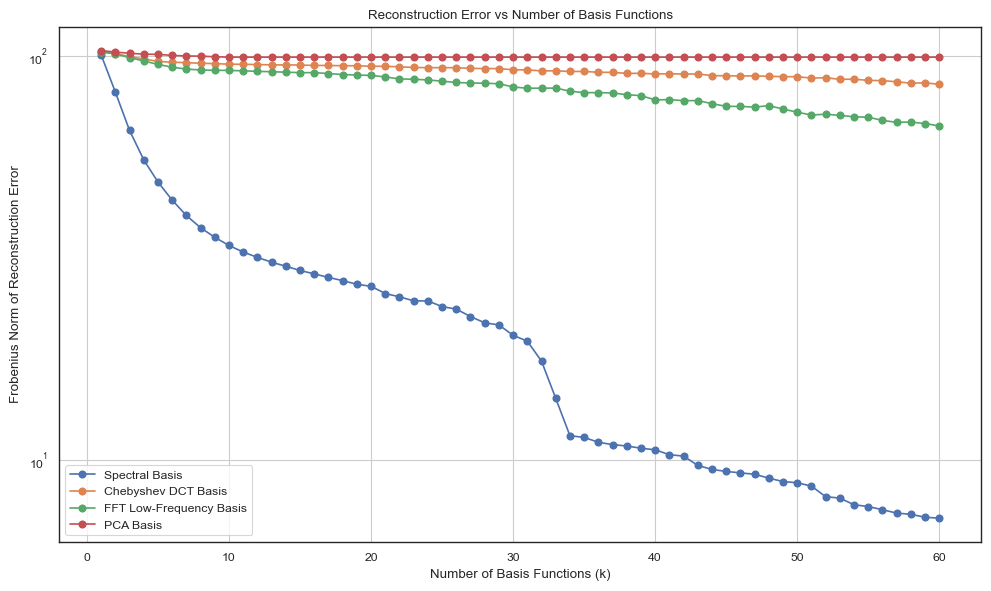

In [70]:
ks = np.arange(1, 61)
errs_h, errs_c, errs_f, errs_p = [], [], [], []
eigvals, eigvecs = construct_hankel_matrix(T)
for k_i in ks:
    Phi_lds_spec = spectral_basis(U_lds, k=k_i, eigvals=eigvals, eigvecs=eigvecs)
    M, _, _, _ = np.linalg.lstsq(Phi_lds_spec, Y_lds, rcond=None)
    errs_h.append(np.linalg.norm(Y_lds - Phi_lds_spec @ M, ord='fro'))

    Phi_lds_cheby = chebyshev_dct_basis(U_lds, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_lds_cheby, Y_lds, rcond=None)
    errs_c.append(np.linalg.norm(Y_lds - Phi_lds_cheby @ M, ord='fro'))

    Phi_lds_fft = fft_lowfreq_basis(U_lds, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_lds_fft, Y_lds, rcond=None)
    errs_f.append(np.linalg.norm(Y_lds - Phi_lds_fft @ M, ord='fro'))

    Phi_lds_pca = time_pca_basis(U_lds, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_lds_pca, Y_lds, rcond=None)
    errs_p.append(np.linalg.norm(Y_lds - Phi_lds_pca @ M, ord='fro'))

plt.figure(figsize=(10, 6))
plt.plot(ks, errs_h, label='Spectral Basis', marker='o')
plt.plot(ks, errs_c, label='Chebyshev DCT Basis', marker='o')
plt.plot(ks, errs_f, label='FFT Low-Frequency Basis', marker='o')
plt.plot(ks, errs_p, label='PCA Basis', marker='o')
plt.yscale('log')
plt.xlabel('Number of Basis Functions (k)')
plt.ylabel('Frobenius Norm of Reconstruction Error')
plt.title('Reconstruction Error vs Number of Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

NAR Experiments

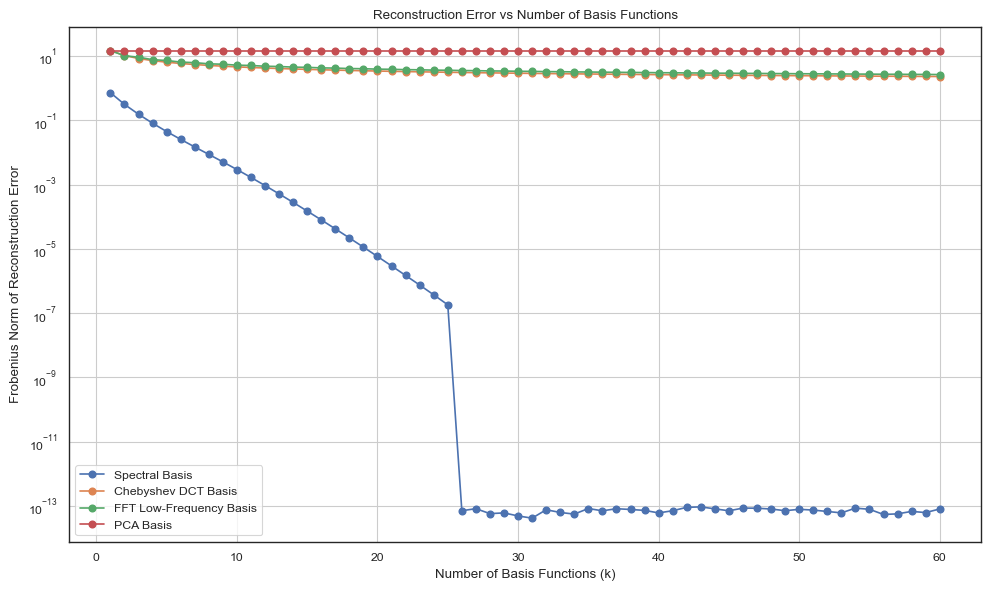

In [71]:
ks = np.arange(1, 61)
errs_h, errs_c, errs_f, errs_p = [], [], [], []
eigvals, eigvecs = construct_hankel_matrix(T)
for k_i in ks:
    Phi_nar_spec = spectral_basis(X_nar, k=k_i, eigvals=eigvals, eigvecs=eigvecs)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_spec, X_nar, rcond=None)
    errs_h.append(np.linalg.norm(X_nar - Phi_nar_spec @ M, ord='fro'))

    Phi_nar_cheby = chebyshev_dct_basis(X_nar, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_cheby, X_nar, rcond=None)
    errs_c.append(np.linalg.norm(X_nar - Phi_nar_cheby @ M, ord='fro'))

    Phi_nar_fft = fft_lowfreq_basis(X_nar, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_fft, X_nar, rcond=None)
    errs_f.append(np.linalg.norm(X_nar - Phi_nar_fft @ M, ord='fro'))
    Phi_nar_pca = time_pca_basis(X_nar, k=k_i)
    
    M, _, _, _ = np.linalg.lstsq(Phi_nar_pca, X_nar, rcond=None)
    errs_p.append(np.linalg.norm(X_nar - Phi_nar_pca @ M, ord='fro'))
    
plt.figure(figsize=(10, 6))
plt.plot(ks, errs_h, label='Spectral Basis', marker='o')
plt.plot(ks, errs_c, label='Chebyshev DCT Basis', marker='o')
plt.plot(ks, errs_f, label='FFT Low-Frequency Basis', marker='o')
plt.plot(ks, errs_p, label='PCA Basis', marker='o')
plt.yscale('log')
plt.xlabel('Number of Basis Functions (k)')
plt.ylabel('Frobenius Norm of Reconstruction Error')
plt.title('Reconstruction Error vs Number of Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

Logistic Experiments

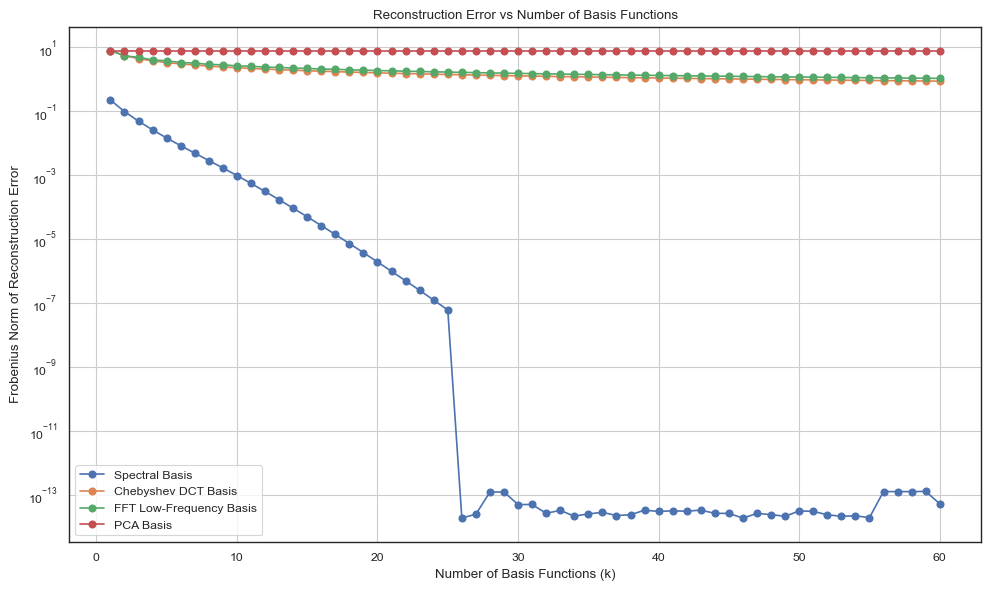

In [69]:
ks = np.arange(1, 61)
errs_h, errs_c, errs_f, errs_p = [], [], [], []
eigvals, eigvecs = construct_hankel_matrix(T)
for k_i in ks:
    Phi_nar_spec = spectral_basis(X_logistic, k=k_i, eigvals=eigvals, eigvecs=eigvecs)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_spec, X_logistic, rcond=None)
    errs_h.append(np.linalg.norm(X_logistic - Phi_nar_spec @ M, ord='fro'))

    Phi_nar_cheby = chebyshev_dct_basis(X_logistic, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_cheby, X_logistic, rcond=None)
    errs_c.append(np.linalg.norm(X_logistic - Phi_nar_cheby @ M, ord='fro'))

    Phi_nar_fft = fft_lowfreq_basis(X_logistic, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_fft, X_logistic, rcond=None)
    errs_f.append(np.linalg.norm(X_logistic - Phi_nar_fft @ M, ord='fro'))

    Phi_nar_pca = time_pca_basis(X_logistic, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_pca, X_logistic, rcond=None)
    errs_p.append(np.linalg.norm(X_logistic - Phi_nar_pca @ M, ord='fro'))

plt.figure(figsize=(10, 6))
plt.plot(ks, errs_h, label='Spectral Basis', marker='o')
plt.plot(ks, errs_c, label='Chebyshev DCT Basis', marker='o')
plt.plot(ks, errs_f, label='FFT Low-Frequency Basis', marker='o')
plt.plot(ks, errs_p, label='PCA Basis', marker='o')
plt.yscale('log')
plt.xlabel('Number of Basis Functions (k)')
plt.ylabel('Frobenius Norm of Reconstruction Error')
plt.title('Reconstruction Error vs Number of Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

Lorenz Experiments

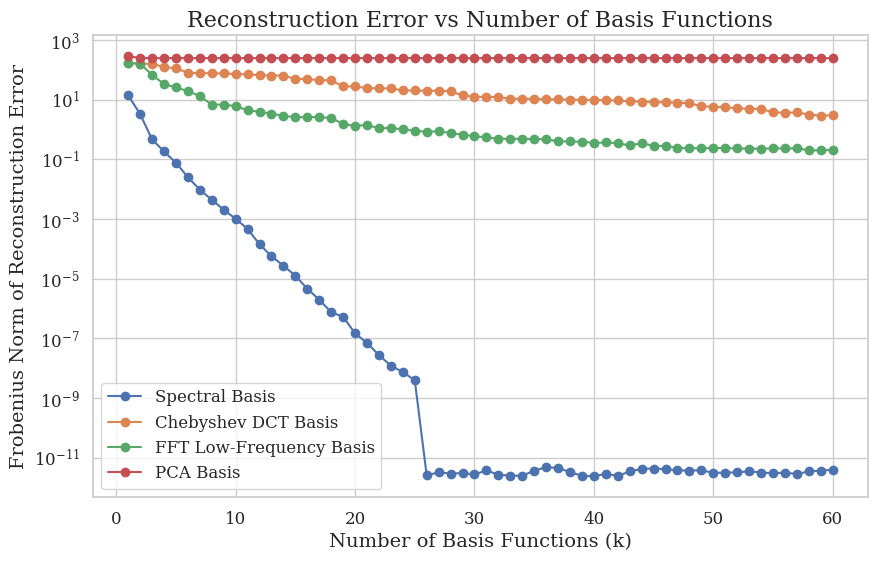

In [35]:
ks = np.arange(1, 61)
errs_h, errs_c, errs_f, errs_p = [], [], [], []
eigvals, eigvecs = construct_hankel_matrix(T)
for k_i in ks:
    Phi_nar_spec = spectral_basis(X_lorenz, k=k_i, eigvals=eigvals, eigvecs=eigvecs)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_spec, X_lorenz, rcond=None)
    errs_h.append(np.linalg.norm(X_lorenz - Phi_nar_spec @ M, ord='fro'))

    Phi_nar_cheby = chebyshev_dct_basis(X_lorenz, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_cheby, X_lorenz, rcond=None)
    errs_c.append(np.linalg.norm(X_lorenz - Phi_nar_cheby @ M, ord='fro'))

    Phi_nar_fft = fft_lowfreq_basis(X_lorenz, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_fft, X_lorenz, rcond=None)
    errs_f.append(np.linalg.norm(X_lorenz - Phi_nar_fft @ M, ord='fro'))
    
    Phi_nar_pca = time_pca_basis(X_lorenz, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_pca, X_lorenz, rcond=None)
    errs_p.append(np.linalg.norm(X_lorenz - Phi_nar_pca @ M, ord='fro'))
plt.figure(figsize=(10, 6))
plt.plot(ks, errs_h, label='Spectral Basis', marker='o')
plt.plot(ks, errs_c, label='Chebyshev DCT Basis', marker='o')
plt.plot(ks, errs_f, label='FFT Low-Frequency Basis', marker='o')
plt.plot(ks, errs_p, label='PCA Basis', marker='o')
plt.yscale('log')
plt.xlabel('Number of Basis Functions (k)')
plt.ylabel('Frobenius Norm of Reconstruction Error')
plt.title('Reconstruction Error vs Number of Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

RNN Results

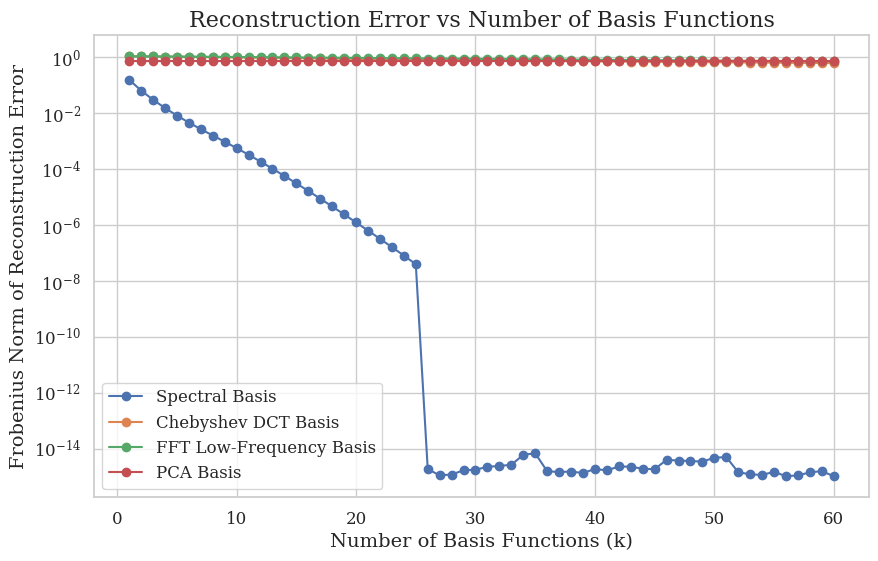

In [34]:
ks = np.arange(1, 61)
errs_h, errs_c, errs_f, errs_p = [], [], [], []
eigvals, eigvecs = construct_hankel_matrix(T)
for k_i in ks:
    Phi_nar_spec = spectral_basis(X_rnn, k=k_i, eigvals=eigvals, eigvecs=eigvecs)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_spec, X_rnn, rcond=None)
    errs_h.append(np.linalg.norm(X_rnn - Phi_nar_spec @ M, ord='fro'))

    Phi_nar_cheby = chebyshev_dct_basis(X_rnn, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_cheby, X_rnn, rcond=None)
    errs_c.append(np.linalg.norm(X_rnn - Phi_nar_cheby @ M, ord='fro'))

    Phi_nar_fft = fft_lowfreq_basis(X_rnn, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_fft, X_rnn, rcond=None)
    errs_f.append(np.linalg.norm(X_rnn - Phi_nar_fft @ M, ord='fro'))
    
    Phi_nar_pca = time_pca_basis(X_rnn, k=k_i)
    M, _, _, _ = np.linalg.lstsq(Phi_nar_pca, X_rnn, rcond=None)
    errs_p.append(np.linalg.norm(X_rnn - Phi_nar_pca @ M, ord='fro'))
plt.figure(figsize=(10, 6))
plt.plot(ks, errs_h, label='Spectral Basis', marker='o')
plt.plot(ks, errs_c, label='Chebyshev DCT Basis', marker='o')
plt.plot(ks, errs_f, label='FFT Low-Frequency Basis', marker='o')
plt.plot(ks, errs_p, label='PCA Basis', marker='o')
plt.yscale('log')
plt.xlabel('Number of Basis Functions (k)')
plt.ylabel('Frobenius Norm of Reconstruction Error')
plt.title('Reconstruction Error vs Number of Basis Functions')
plt.legend()
plt.grid(True)
plt.show()